# Loading data 

In this section, a ".zip" file is loaded with the images, both training and test, to be able to build the model and test its efficiency. 

It also loads the ". csv" file  with test labels, which were provided at the end of the Kaggle competition, to evaluate the efficiency of the classifier.

In drive, both the ".zip" file and the ".csv" file were uploaded and shared by any user who has the link to the aforementioned files.




In [ ]:
# Through !gdown proceeds to download the '.zip' file which is at that address 
# And the data is saved in the Files section of 'google colab'
!gdown https://drive.google.com/u/0/uc?id=1qe1ER8kMGQzRvWrJrJf9frgoKnK1ufwU
!echo "unzipping"
# By !unzip the data in the '.zip' file is decompressed
!unzip -q data.zip
!echo "removing trash"
!rm data.zip
# Through !gdown proceeds to download the file '.csv' that is at that address 
# And that file is saved in the Files section of 'google colab'
!gdown https://drive.google.com/u/0/uc?id=1tyLFGrFbbY8_QHKDbkzXxlhY3s5H9RGq

Downloading...
From: https://drive.google.com/u/0/uc?id=1qe1ER8kMGQzRvWrJrJf9frgoKnK1ufwU
To: /content/data.zip
82.7MB [00:01, 74.1MB/s]
unzipping
removing trash
Downloading...
From: https://drive.google.com/u/0/uc?id=1tyLFGrFbbY8_QHKDbkzXxlhY3s5H9RGq
To: /content/testLabels.csv
100% 9.59k/9.59k [00:00<00:00, 16.1MB/s]


#Libraries 

In this section the libraries to be used during the code are loaded.

It also checks whether the runtime environment being used is "cuda", that is, whether a "GPU hardware accelerator" is being used, or whether it is being used as a "cpu" runtime environment. 

In this case to work with neural networks it is better to work with "cuda" since a high computational capacity is needed for training and subsequent analysis of images.


In [ ]:
# Numpy
import numpy  as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib.pyplot as plt 
plt.style.use('default')

# Itertools
import itertools

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data import sampler
import torchvision
import torchvision.datasets as dset

from torchvision import transforms, utils, datasets

# Function to load images in the Prediction section
from PIL import *
from torch.autograd import Variable

# To paint the ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# To paint the confusion matrix
from sklearn.metrics import confusion_matrix


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
root_dir = './data/'

We're using => cuda


# Transformations and Creation of Training and Validation Data

This section defines the transformations that are applied on the training set and on the test set.

In both sets, both in the training images and in the set of test images, the following transformations are applied:

*   transforms.Resize (size=(150,150)) --> So that all images have the same size 150 x 150. 
*   transforms.ToTensor() --> To turn each image into a tensor and work with the images afterwards.
*   Transforms.Normalize([0.485, 0.456, 0.406],                              [0.229, 0.224, 0.225]) --> To have a certain independence from the properties of the image, such as brightness and contrast, and to be able to compare fingerprints by their quality index (QI).

On the other hand, in the training set, in the images of "train", in addition other transformations are applied in order that, during the training stage, the model does not learn a pixel in the same way, but learns it in different ways, which helps to create a model that provides more reliable results.

These transformations are as follows:

*   transforms.RandomRotation(degrees=15) --> To apply a random rotation of the image of about 15 degrees.
*   transforms.ColorJitter() --> To alter the color of the image.

*   transforms.RandomHorizontalFlip() --> To perform a random horizontal flip on each image.

After creating the transformations for the training set and for the test set, the training images are taken using the Python function "datasets.ImageFolder" in which the direction of the training images is indicated and their transformations are applied.

Finally, the data is separated into "train_loader" training set and "val_loader" validation set to work with them during training and thus train the created model.


In [ ]:
# Transformations for training images.
image_transforms_train =    transforms.Compose([
        transforms.Resize(size=(150,150)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]) 
    ])

# Transformations for test images. 
image_transforms_test =  transforms.Compose([
        transforms.Resize(size=(150,150)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])

# The training images are taken and their transformations are applied.
dataset = datasets.ImageFolder(root = root_dir + '/train',
                                      transform = image_transforms_train
                                     )

# Separate the training picture set into a training set 'train_loader' and a validation set 'val_loader'. 
dataset_size = len(dataset)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.2 * dataset_size))
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
train_loader = DataLoader(dataset=dataset, shuffle=False, batch_size=100, sampler=train_sampler)
val_loader = DataLoader(dataset=dataset, shuffle=False, batch_size=100, sampler=val_sampler)

#Creation of the network 

In this section the CNN model is created to generate the convolutional neural network and carry out the classification of images. 

It consists of convolutional layers, MaxPool2d layers, ReLU activation functions, linear layers and is applied Dropout, too, so that the model does not over-adjust

In [ ]:
class MaskDetection(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3), # The output you get is --> 100*148*148
            nn.ReLU(),
            nn.MaxPool2d(2), # The output you get is --> 100*74*74. 

            nn.Conv2d(100, 100, kernel_size=3), # The output you get is --> 100*72*72
            nn.ReLU(),
            nn.MaxPool2d(2), # The output you get is --> 100*36*36

            nn.Flatten(), 
            nn.Dropout(0.5),
            nn.Linear(100*36*36, 50), # The input size of the first linear layer is the output size of the last MaxPool2d layer
            nn.ReLU(),
            nn.Linear(50, 2))
        
    def forward(self, xb):
        return self.network(xb)

# Training

The training model is defined in this section.

To do this, first define the function 'EarlyStopping' to be used in the training function 'train_model'.

**The Early Stop process acts as follows:***

Once the average validation error of all the interactions performed in an epoch has been calculated, if that validation error is less than the previous one, that is, in the previous epoch, the process is continued.

At first, a counter variable should be created, which increases one by one if the validation error is greater than the validation error obtained in the previous epoch.

This counter will increase to a certain number "patience" that is defined at the beginning.

At the moment that the counter is greater or equal to "patience", the program is told to stop, since it is overfitting and the model that was previously obtained is preserved, that is to take and load the best weights that were kept.

This way the model gets the best weights. 

In the event that the validation error is less than the previous one, the counter must be initialized to zero, and the execution continues.

Whenever the validation error decreases (it is less than the previous one) this model must be saved so as not to lose those data during training.












In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def train_model(model, batch_size, patience, n_epochs):
    
    # List in which the training loss is stored as the model is trained.
    train_losses = []
    # List where the validation loss is stored as the model is trained.
    valid_losses = []
    # List in which the average of the training loss per epoch is stored as the model is trained.
    avg_train_losses = []
    # List in which the averages of the loss of validation per epoch are stored as the model is trained.
    avg_valid_losses = [] 
    
    # The early_stopping object is initialized
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    # All the epochs are covered
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        # Puts the model in training mode
        model.train() 

        # All training data "train_loader" is traversed
        for batch, (data, target) in enumerate(train_loader, 1):

            # Zero all gradients of the variables that the optimizer will update.
            optimizer.zero_grad()

            # Move to device, e.g. GPU. 
            data = data.to(device)
            target = target.to(device)

            # This is the forward step, the expected outputs are calculated by passing the data (train_loader images) to the model.
            output = model(data)

            # The training error is calculated using the criterion given below.
            loss = criterion(output, target)

            # This is the backward step, the loss gradient is calculated with respect to each parameter of the model.         
            loss.backward()

            # Model parameters are updated using the gradients calculated by backward step.       
            optimizer.step()

            # The training loss is stored in the list defined at the beginning.
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        # The model is put into validation mode
        model.eval() 

        # All validation data "val_loader" is traversed
        for data, target in val_loader:

            # Move to device, e.g. GPU. 
            data = data.to(device)            
            target = target.to(device)

            # This is the forward step, the expected outputs are calculated by passing the data (the val_loader images) to the model.
            output = model(data)

            # The training error is calculated using the criterion given below.
            loss = criterion(output, target)

            # The validation loss is stored in the list defined at the beginning
            valid_losses.append(loss.item())

        # Training / validation statistics are printed and the average loss during an epoch is calculated        
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # Lists are 'cleared' to store new training and validation error values in the next epoch
        train_losses = []
        valid_losses = []

        # Early_stopping needs validation loss to check if its value has decreased, and if it has, 
        #it will make a control point of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # The last control point is loaded with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    # The final model, its average training error and its average validation error are returned.
    return  model, avg_train_losses, avg_valid_losses

After defining the EarlyStopping function and the training function, we proceed to train our model.

*   Create an instance of the model 'modelMask' which is the CNN network that has been previously defined.

*   The device to be used during training is defined as 'cuda'.

*   The optimizer to be used is defined. In this work the "Adam optimizer" will be used, which is considered as a method of stochastic optimization. It is a technique that implements the adaptive learning rate, while in the "normal SGD optimizer" it does not because the learning rate has an equivalent kind of effect for all weights / model parameters.

*   The cost function "Cross Entropy" is set as the criterion for calculating the training and validation error.

Finally, the function 'train_model' is passed the parameters (model, batch_size, patience, number of epochs)






In [ ]:
modelMask = MaskDetection()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    modelMask.cuda()

optimizer = optim.Adam(modelMask.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

model, train_loss, valid_loss = train_model(modelMask, 100, 7, 100)

[  1/100] train_loss: 0.31083 valid_loss: 0.09004
Validation loss decreased (inf --> 0.090037).  Saving model ...
[  2/100] train_loss: 0.08187 valid_loss: 0.12871
EarlyStopping counter: 1 out of 7
[  3/100] train_loss: 0.07126 valid_loss: 0.09084
EarlyStopping counter: 2 out of 7
[  4/100] train_loss: 0.06642 valid_loss: 0.08579
Validation loss decreased (0.090037 --> 0.085795).  Saving model ...
[  5/100] train_loss: 0.06563 valid_loss: 0.08613
EarlyStopping counter: 1 out of 7
[  6/100] train_loss: 0.06494 valid_loss: 0.09519
EarlyStopping counter: 2 out of 7
[  7/100] train_loss: 0.05896 valid_loss: 0.05529
Validation loss decreased (0.085795 --> 0.055288).  Saving model ...
[  8/100] train_loss: 0.05381 valid_loss: 0.05976
EarlyStopping counter: 1 out of 7
[  9/100] train_loss: 0.04539 valid_loss: 0.05997
EarlyStopping counter: 2 out of 7
[ 10/100] train_loss: 0.04552 valid_loss: 0.05872
EarlyStopping counter: 3 out of 7
[ 11/100] train_loss: 0.04752 valid_loss: 0.04891
Validation

# Classification of test images

The 'image_loader' function is created in order to take the test images by order one at a time to classify them.

In [ ]:
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = image_transforms_test(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  
    return image.cuda() 

Two lists are created: probab and predictions.

In "probab" the probabilities of a mask appearing in the photos are stored. 

And predictions are stored in "redictions".

In [ ]:
probab=[]
predictions = []

for i in range(1,1527):
  # Images are taken one at a time in order.
  image = image_loader('./data/test/test/'+str(i)+'.jpg')
  # A test image is passed by the trained model.
  scores = model(image)  
  # Scores are passed through the Softmax function so that the vector of scores becomes another vector 
  # of real values within the range [0,1].
  prob = F.softmax(scores, dim=1)
  # Probabilities become a list
  # For each image, there is the probability that there is a mask and the probability that there is no mask.
  prob2 = prob.tolist() 
  prob3 = prob2[0]
  # It becomes an array in order to take only the probability that there is mask in each image.  
  my_array = np.array(prob3)
  # The probabilities of having a mask in the previously defined list are stored. 
  probab.append(my_array[0]) 
  # Predictions are calculated
  _, preds = scores.max(1)
  # Predictions are stored in the previously defined list.
  predictions.append(preds.data.item())

#Save file ". csv" 

In this section, the probabilities that in the images there is mask, are saved in a.csv file. 

This '.csv' is the one that got into the Kaggle competition.

In [ ]:
ids = [i+1 for i in range(1526)]

sampleSubmission = pd.DataFrame({'Id':ids,'Predicted':probab})
sampleSubmission.to_csv('Submision.csv',index=False)

# ROC Curve 

In this section we proceed to paint the ROC curve since the evaluation metric to measure the performance of the classifier is "AUC" "Area Under the curve", which is based on the false alarm probability and the detection probability.

In [ ]:
import pandas as pd
# The file '.csv' is loaded.
datos = pd.read_csv("testLabels.csv")
# All rows and all columns of the file data are taken.
etiquetas1 = datos.iloc[:,:]

# Using the Python "drop" function, the Id column is deleted, as it is not needed. 
etiquetas = etiquetas1.drop('Id',axis=1)

# The values are stored in a list so you can work with it and paint the ROC curve. 
etiquetasList = []
for i in range (len(etiquetas)):
  etiquetasList.append(etiquetas.iloc[i,0])

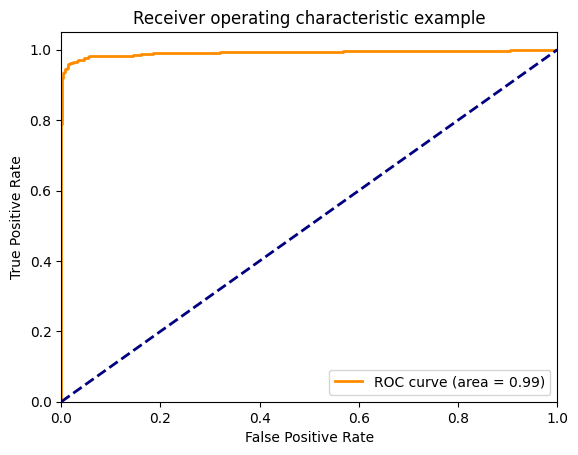

In [ ]:
# Calculate the ROC curve and the ROC area for each class.
fpr = dict()
tpr = dict()
roc_auc = dict()
# There are two classes since it is a binary classification problem.
n_classes = 2

# Calculate the True Positive Rate and the False Positive Rate. 
fpr, tpr, _ = roc_curve(etiquetasList, probab)
# Calculate the value of the "Area under the curve"
roc_auc = auc(fpr, tpr)

# The ROC curve is drawn.
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix 

Another procedure to measure the performance of the classifier is to represent the confusion matrix.

'0' means that the image had a mask. 

'1' means that the image did not have a mask.



In [ ]:
predictionsNew = []

for i in range (len(predictions)):
  if predictions[i] == 1:
    predictionsNew.append(0)
  elif predictions[i] == 0:
    predictionsNew.append(1)


To paint the confusion matrix a function called "plot_confusion_matrix" has been defined.

Confusion matrix, without normalization
[[1183    7]
 [  21  315]]


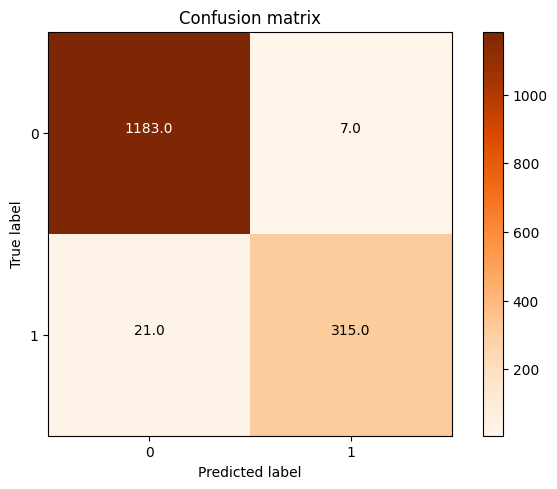

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks()).astype(str))
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(etiquetasList, predictionsNew)
np.set_printoptions(precision=1) 
print('Confusion matrix, without normalization')
print(cm)
fig, ax = plt.subplots()
plot_confusion_matrix(cm)

plt.show()